In [29]:
import pandas as pd  
import numpy as np
import os
import scipy.optimize as sco
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
np.random.seed(233)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [30]:
file_path = ["./Dataset/" + file_name for file_name in os.listdir("./Dataset")]
Mon_map = {
        'Dec': '12',
        'Nov': '11',
        'Oct': '10',
        'Sep': '09',
        'Aug': '08',
        'Jul': '07',
        'Jun': '06',
        'May': '05',
        'Apr': '04',
        'Mar': '03',
        'Feb': '02',
        'Jan': '01'
    }
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]

In [31]:
# 11 kinds of colors for 11 tickers
colors =[  'springgreen', 'lightseagreen', 'darkcyan', 
            'steelblue', 'yellowgreen', 'firebrick', 
            'fuchsia', 'darkorange', 'tomato', 'plum', 'crimson']

## 💾 Data Preparation

In [32]:
# -- all data
yearly_data = []
for year in years:
    temp = pd.DataFrame(columns=['Date', 'Price', 'ticker'])
    for file in file_path:
        df = pd.read_csv(file).loc[:,["Date", "Price"]]
        df["Date"] = df["Date"].apply(lambda x: x[-4:] + "-" + Mon_map[x[:3]] + "-" + x[4:6])
        df["ticker"] = file[10:13]
        lis = df.Date.apply(lambda x: x[0:4] == year)
        temp = pd.concat([temp, df[lis]])
    yearly_data.append(temp)

In [33]:
# -- assign the year to plot
df = yearly_data[0]
for i in range(1, 11):
    df = df.append(yearly_data[i])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30693 entries, 2770 to 532
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    30693 non-null  object
 1   Price   30693 non-null  object
 2   ticker  30693 non-null  object
dtypes: object(3)
memory usage: 959.2+ KB


In [34]:
# -- set index
df = df.set_index('Date')
df.head()

,Price,ticker
Date,,
2010-12-31,54.23,QQQ
2010-12-30,54.43,QQQ
2010-12-29,54.56,QQQ
2010-12-28,54.44,QQQ
2010-12-27,54.54,QQQ


In [35]:
# -- change data formate, table contains all years' data
all_years_data = df.pivot(columns='ticker')
all_years_data.columns = [col[1] for col in all_years_data.columns]
all_years_data.head()

,QQQ,VNQ,VOX,XLB,XLE,XLF,XLI,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,
2010-01-04,46.23,44.55,57.72,34.02,57.1,11.93,28.32,26.67,31.08,31.41,30.0
2010-01-05,46.23,44.5,58.11,34.13,57.57,12.15,28.42,26.68,30.71,31.1,30.11
2010-01-06,45.95,44.42,57.19,34.71,58.26,12.17,28.48,26.66,30.89,31.42,30.15
2010-01-07,45.98,44.9,56.98,34.44,58.17,12.43,28.79,26.66,30.75,31.52,30.4
2010-01-08,46.36,44.57,56.72,34.92,58.55,12.36,29.25,26.57,30.72,31.57,30.39


In [36]:
# -- choose data of identical year
individual_year = "2017" # to analyze other years' data, just change the number
individual_year_data = all_years_data.loc[all_years_data.index.str.contains(individual_year)]
individual_year_data.head()

,QQQ,VNQ,VOX,XLB,XLE,XLF,XLI,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,
2017-01-03,119.54,82.8,103.42,49.99,73.96,23.51,62.59,51.9,48.45,69.39,81.88
2017-01-04,120.19,84.01,104.13,50.72,73.8,23.7,62.96,51.9,48.63,69.93,82.97
2017-01-05,120.87,84.28,103.37,50.57,73.62,23.46,62.78,52.07,48.68,70.29,82.91
2017-01-06,121.93,84.29,101.94,50.62,73.69,23.54,63.14,52.12,48.83,70.49,83.32
2017-01-09,122.33,83.53,100.95,50.61,72.62,23.38,62.65,51.7,48.19,70.79,83.25


In [37]:
# -- compute returns (daily)
returns_one_year = individual_year_data.pct_change()
mean_returns = returns_one_year.mean()
cov_matrix = returns_one_year.cov()
asset_num = 11 # individuals num
num_portfolios = 10000 # random portfolio nums
risk_free_rate = 0.0181 # one year treasury bill
max_return = max(mean_returns)*252 # assume 252 trading days per year

### 🎰Optimal Market Portfolio

In [38]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [39]:
# -- generate random portfolios
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(asset_num)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [40]:
results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

In [41]:
def display_simulated_ef_with_random(results, weights):
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=all_years_data.columns,columns=['allocation'])
    max_sharpe_allocation['allocation'] = [round(i*100,2) for i in max_sharpe_allocation['allocation']]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=all_years_data.columns,columns=['allocation'])
    min_vol_allocation['allocation'] = [round(i*100,2) for i in min_vol_allocation['allocation']]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.18
Annualised Volatility: 0.07


              QQQ   VNQ  VOX    XLB   XLE   XLF    XLI    XLP  XLU    XLV  \
allocation  21.84  0.85  0.5  10.76  1.89  4.42  21.14  11.08  5.5  20.85   

             XLY  
allocation  1.16  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.06


              QQQ   VNQ  VOX   XLB   XLE  XLF   XLI    XLP    XLU    XLV   XLY
allocation  12.06  6.21  0.3  1.09  4.73  6.8  2.96  22.78  22.57  11.12  9.36


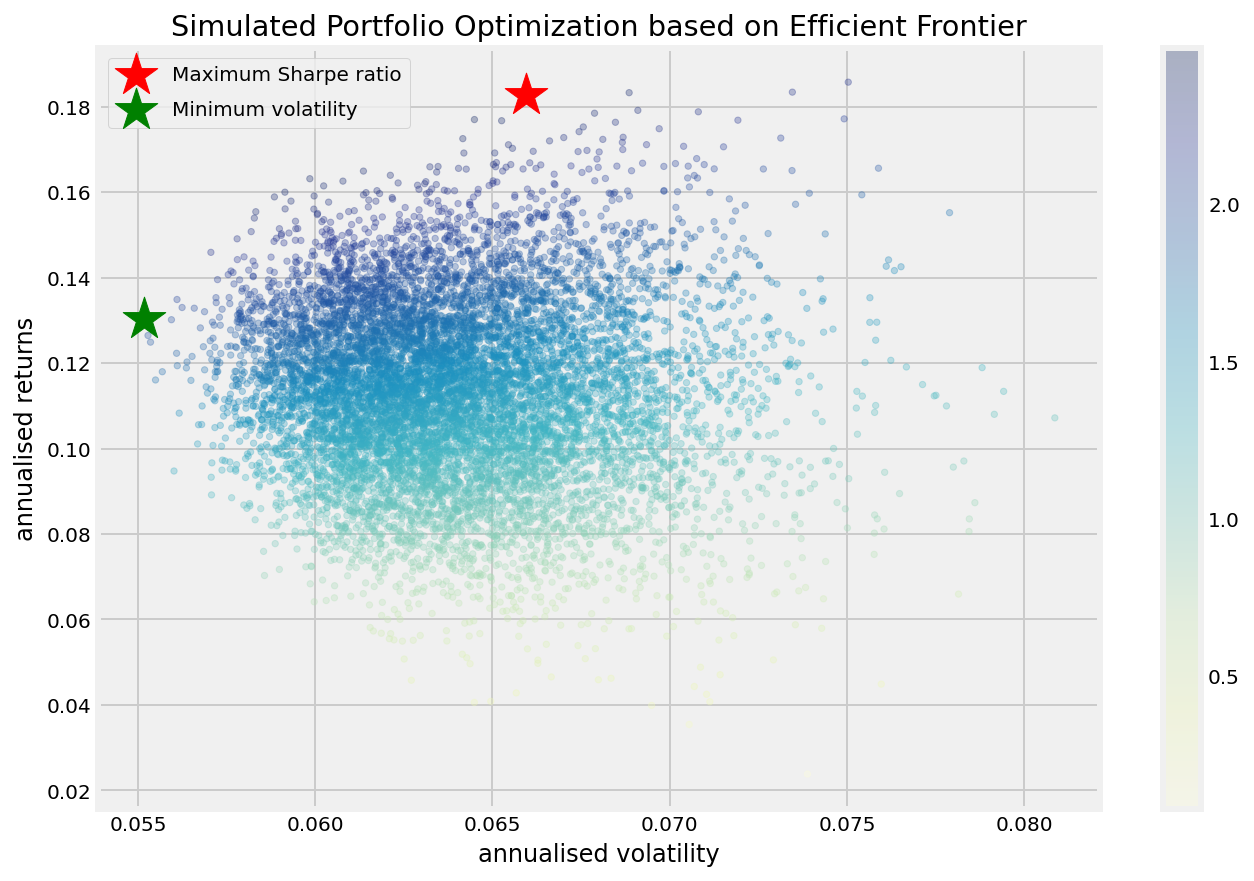

In [42]:
display_simulated_ef_with_random(results, weights)

In [43]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for _ in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [44]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [45]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for _ in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [46]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, results, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=all_years_data.columns,columns=['allocation'])
    max_sharpe_allocation['allocation'] = [round(i*100,2)for i in max_sharpe_allocation['allocation']]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=all_years_data.columns,columns=['allocation'])
    min_vol_allocation['allocation'] = [round(i*100,2)for i in min_vol_allocation['allocation']]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    target = np.linspace(rp_min, max_return, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

    plt.figure(figsize=(14, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.2
Annualised Volatility: 0.07


              QQQ  VNQ  VOX   XLB  XLE  XLF    XLI  XLP    XLU    XLV    XLY
allocation  36.71  0.0  0.0  5.66  0.0  1.0  10.89  0.0  16.05  12.23  17.45
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.05


             QQQ   VNQ  VOX  XLB  XLE  XLF  XLI    XLP    XLU    XLV    XLY
allocation  2.94  0.66  0.0  0.0  8.0  5.9  0.0  22.35  23.59  18.39  18.17


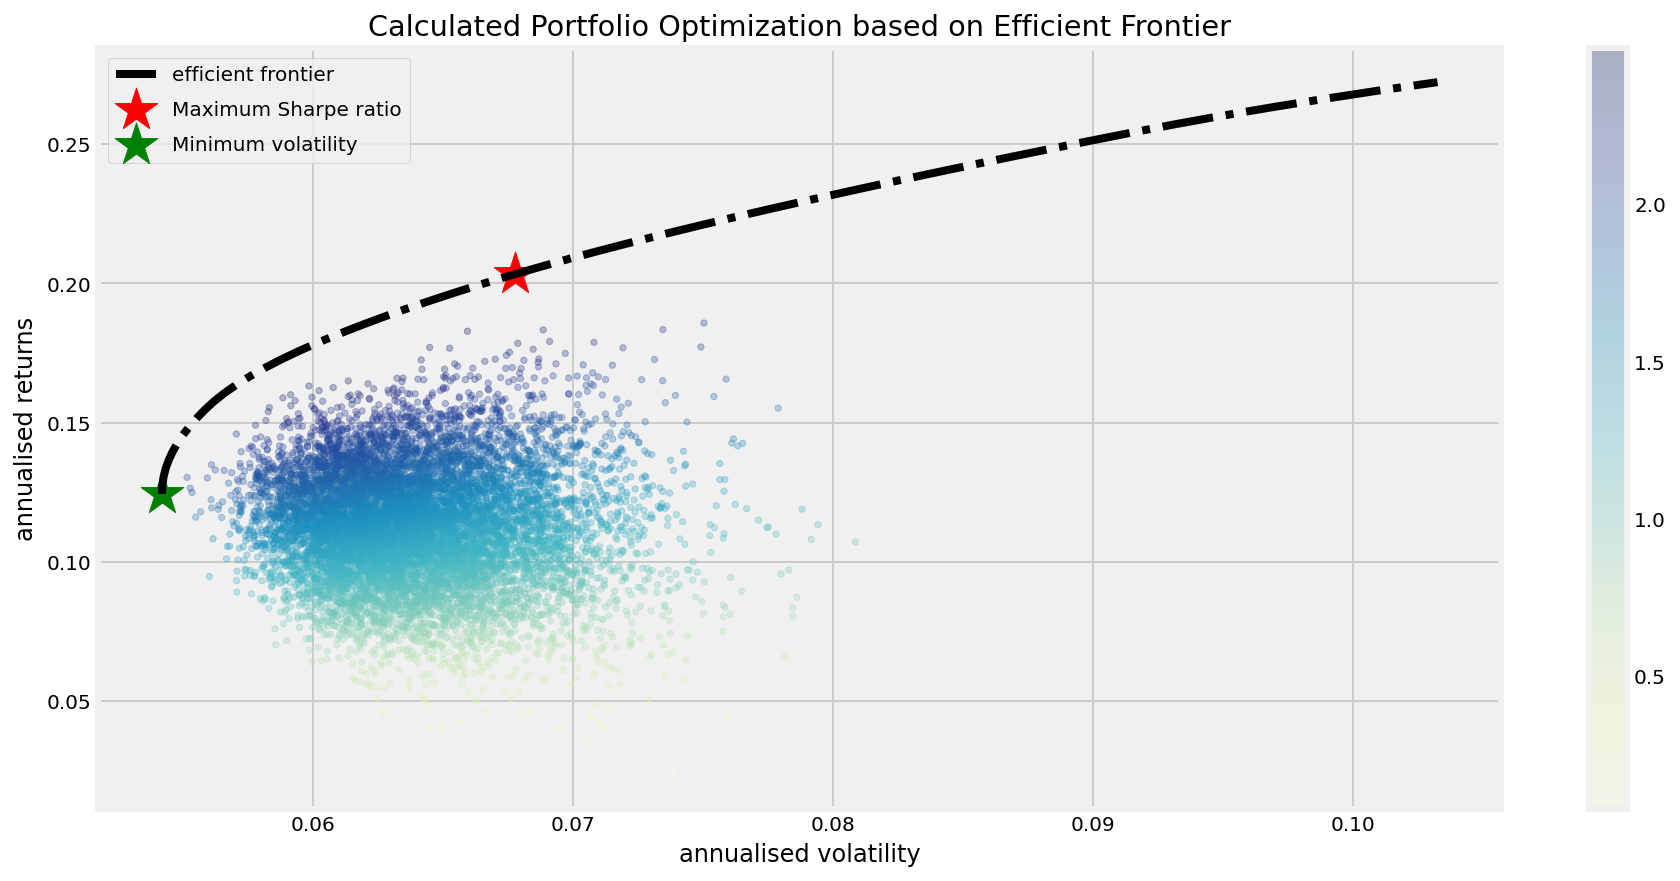

In [47]:
display_calculated_ef_with_random(mean_returns, cov_matrix, results, risk_free_rate)

### 🎯Efficient Frontier

In [48]:
scale = 1.5 # how much the line is extended

In [49]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    print("drawing...", flush = True)
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=all_years_data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=all_years_data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns_one_year) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(all_years_data.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    ax.scatter(0,risk_free_rate,marker='o',color='b',s=50, label='Risk Free rate')
    plt.plot([0, sdp*scale], [risk_free_rate, rp*scale], color = 'orange', linewidth=2.5, label = "Capital Market line")
    target = np.linspace(rp_min, max_return, 100)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    for i, txt in enumerate(all_years_data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')

    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
    return max_sharpe_allocation, min_vol_allocation, sdp, rp 

drawing...
--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.2
Annualised Volatility: 0.07


              QQQ  VNQ  VOX   XLB  XLE  XLF    XLI  XLP    XLU    XLV    XLY
allocation  36.71  0.0  0.0  5.66  0.0  1.0  10.89  0.0  16.05  12.23  17.45
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.05


             QQQ   VNQ  VOX  XLB  XLE  XLF  XLI    XLP    XLU    XLV    XLY
allocation  2.94  0.66  0.0  0.0  8.0  5.9  0.0  22.35  23.59  18.39  18.17
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

QQQ : annuaised return 0.27 , annualised volatility: 0.1
VNQ : annuaised return 0.01 , annualised volatility: 0.1
VOX : annuaised return -0.12 , annualised volatility: 0.14
XLB : annuaised return 0.2 , annual

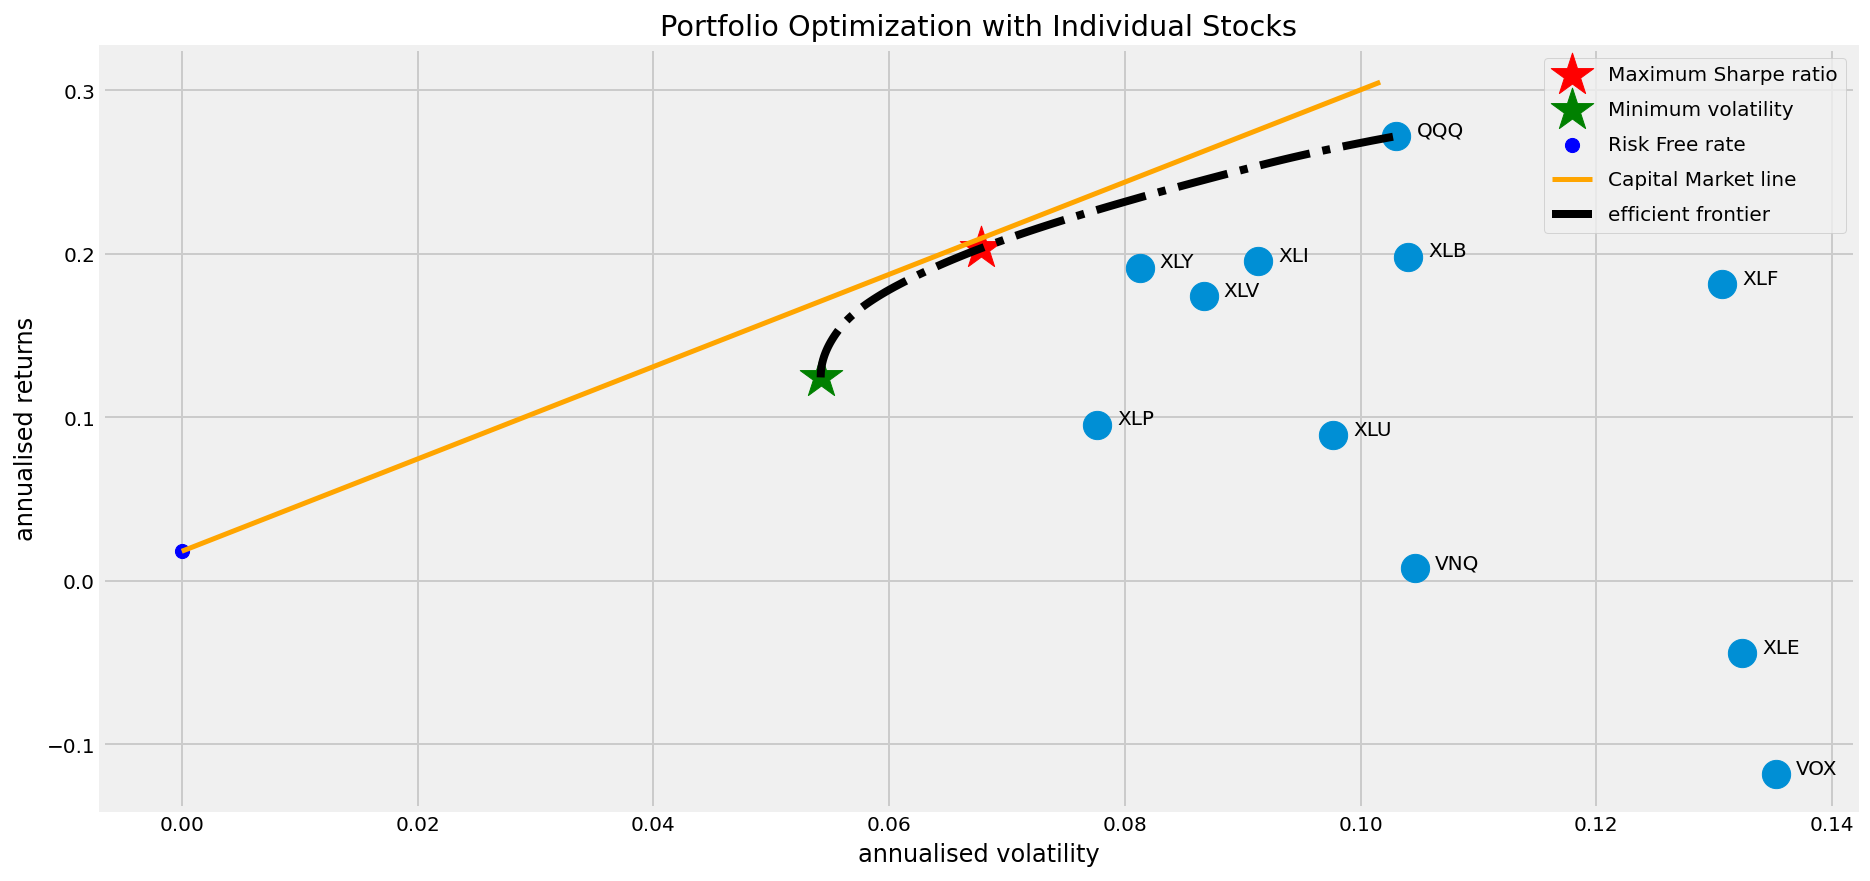

In [50]:
max_sharpe_portfolio, min_vol_portfolio, sd_m, R_m = display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

In [51]:
def draw_portfolio(max_sharpe_portfolio, min_vol_portfolio):
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,5), tight_layout = True)
    axes[0].bar(list(max_sharpe_portfolio.columns), list(max_sharpe_portfolio.iloc[0, :]), color = colors)
    axes[0].set_title("Optimal Market Portfolio")
    axes[0].set_ylim(0, 70)
    axes[0].set_ylabel("Percentage")
    axes[1].bar(list(min_vol_portfolio.columns), list(min_vol_portfolio.iloc[0, :]), color = colors)
    axes[1].set_title("Minimum Volatility Portfolio")
    axes[1].set_ylim(0, 70)
    axes[1].set_ylabel("Percentage")
    plt.show()

--------------------------------------------------------------------------------
Optimal Market Allocation
              QQQ  VNQ  VOX   XLB  XLE  XLF    XLI  XLP    XLU    XLV    XLY
allocation  36.71  0.0  0.0  5.66  0.0  1.0  10.89  0.0  16.05  12.23  17.45
--------------------------------------------------------------------------------
Minimum Volatility Portfolio
             QQQ   VNQ  VOX  XLB  XLE  XLF  XLI    XLP    XLU    XLV    XLY
allocation  2.94  0.66  0.0  0.0  8.0  5.9  0.0  22.35  23.59  18.39  18.17


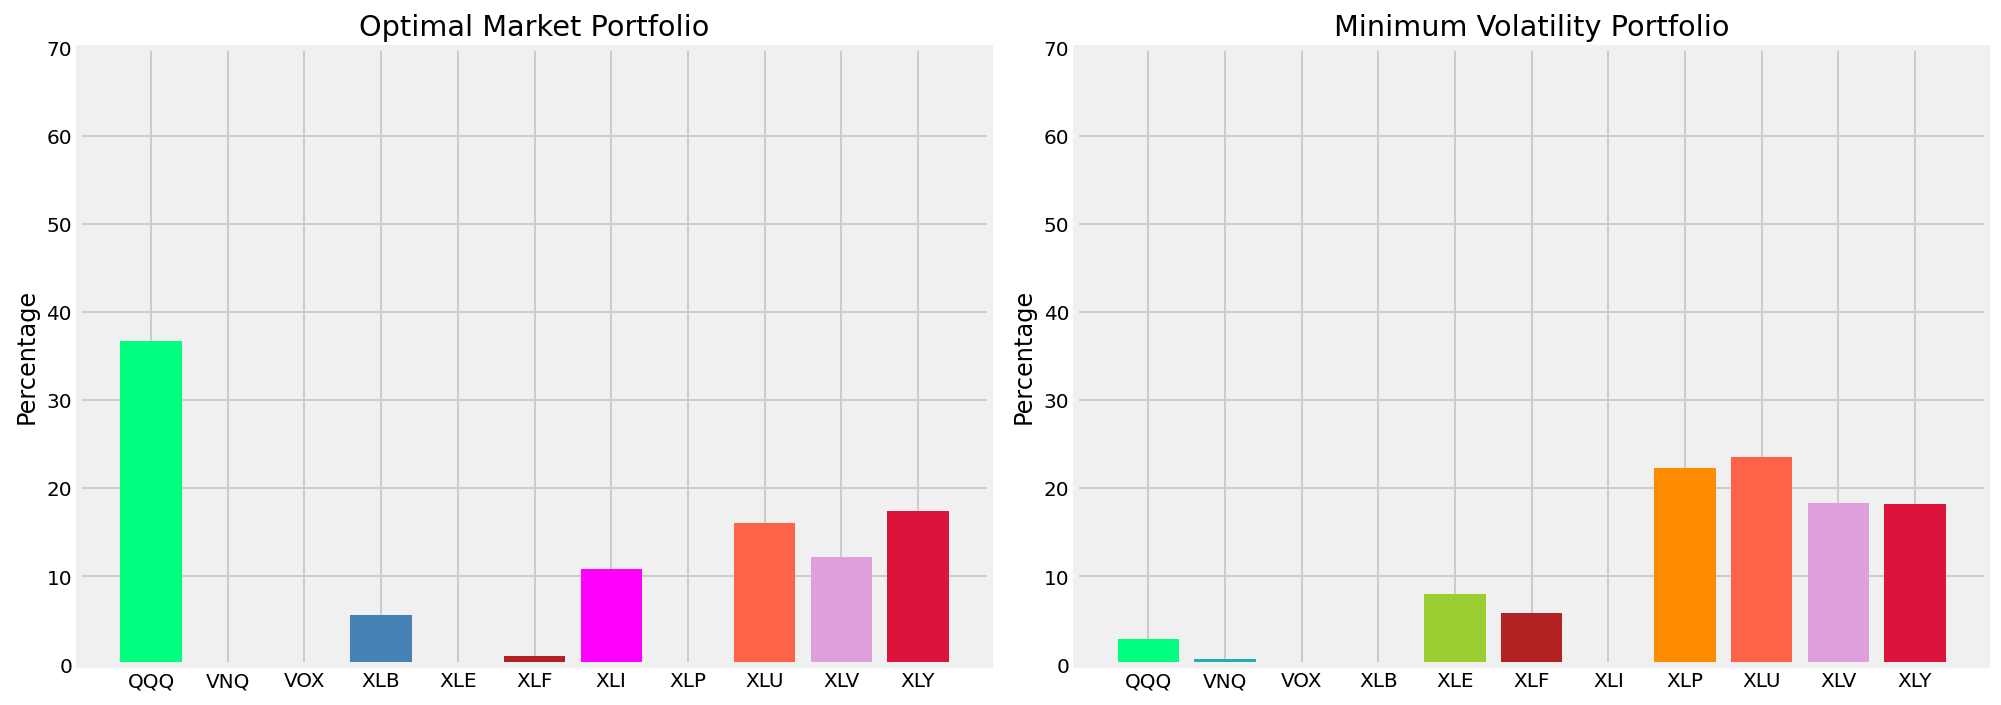

In [52]:
print ("-"*80)
print("Optimal Market Allocation")
print(max_sharpe_portfolio)
print ("-"*80)
print("Minimum Volatility Portfolio")
print(min_vol_portfolio)
draw_portfolio(max_sharpe_portfolio, min_vol_portfolio)

### ✨Investors’ Optimal Portfolios

In [53]:
def draw_investor_portfolio1(max_sharpe_portfolio, optimal_individual_portfolio):
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,5), tight_layout = True)
    axes[0].bar(list(max_sharpe_portfolio.columns), list(max_sharpe_portfolio.iloc[0, :]), color = colors)
    axes[0].set_title("Optimal Market Portfolio")
    # axes[0].set_ylim(0, 100)
    axes[0].set_ylabel("Percentage")
    axes[1].bar(list(optimal_individual_portfolio.columns), list(optimal_individual_portfolio.iloc[0, :]), color = colors + ['grey'])
    axes[1].set_title("Optimal Individual Portfolio")
    # axes[1].set_ylim(, 100)
    axes[1].set_ylabel("Percentage")
    plt.show()

In [54]:
a = 1.2 # w* = a·w_A + (1-a)·w_f

--------------------------------------------------------------------------------
a = 1.2, Optimal Individual Portfolio
               QQQ  VNQ  VOX    XLB  XLE  XLF     XLI  XLP    XLU     XLV  \
allocation  44.052  0.0  0.0  6.792  0.0  1.2  13.068  0.0  19.26  14.676   

              XLY    Rf  
allocation  20.94 -20.0  


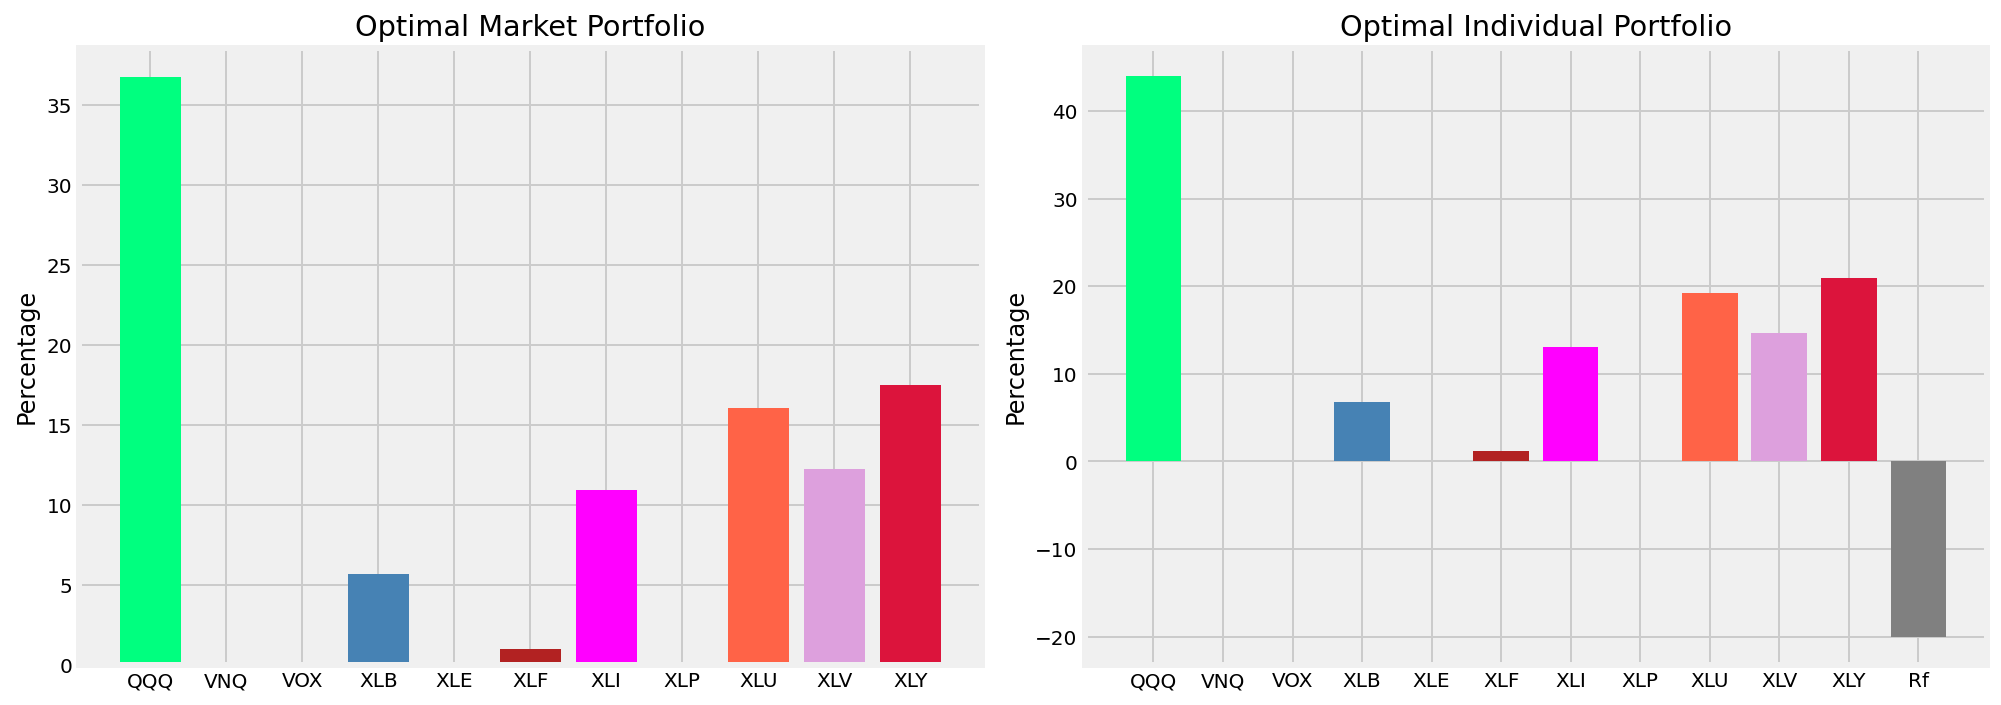

In [55]:
optimal_individual_portfolio = max_sharpe_portfolio * a
optimal_individual_portfolio['Rf'] = 100 * (1 - a)
print ("-"*80)
print(f"a = {a}, Optimal Individual Portfolio")
print(optimal_individual_portfolio)
draw_investor_portfolio1(max_sharpe_portfolio, optimal_individual_portfolio)